#  Automated detection of LV from arterial input function (AIF) image series for cardiac MR perfusion with model deployment to MR scanner

**Author**: `Hui Xue <hui.xue@nih.gov>`

In [1]:
#import os
#os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
#os.environ['CUDA_VISIBLE_DEVICES']='1,2'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.onnx
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.utils import *

import numpy as np
import collections
import matplotlib.pyplot as plt
from matplotlib import animation, rc
animation.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

import scipy
import scipy as sp
from scipy.spatial import ConvexHull
from scipy.ndimage.morphology import binary_fill_holes

from collections import OrderedDict
import time
from tensorboardX import SummaryWriter

from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision

from IPython.display import display, clear_output, HTML, Image

from PIL import Image
import imp
import os
import sys
import math
import time
import random
import shutil
import scipy.misc
from glob import glob
import sklearn
import logging
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import training
import models
import utils
import utils.cmr_ml_utils_plotting

In [3]:
def show(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Load image data

In [4]:
img_dir = './data'

In [7]:
import scipy.io

class PerfAIFDataset(Dataset):
    """Perfusion AIF dataset."""

    def __init__(self, img_dir, which_mask='LV_RV', min_reps=64, W=48, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            which_mask: LV or LV_RV
        """
        self.img_dir = img_dir
        self.transform = transform
        self.which_mask = which_mask
        self.min_reps = min_reps
        self.W = W
        
        # find all images
        locations = os.listdir(self.img_dir)
        a = []
        for loc in locations:
            if(os.path.isdir(os.path.join(self.img_dir, loc))):
                a.extend(os.listdir(os.path.join(self.img_dir, loc)))

        num_samples = len(a)
        print("Found %d cases ... " % num_samples)
        
        self.initialize_storage()

        t0 = time.time()
        print("Start loading cases ... ")
        
        total_num_loaded = 0
        
        for loc in locations:
            if(os.path.isdir(os.path.join(self.img_dir, loc))):
                total_num_loaded = self.load_one_loc(loc, total_num_loaded, t0)                                          
        
        print("Total samples loaded %d " % total_num_loaded)
        
    def initialize_storage(self):
        self.aif = []
        self.lv_rv_masks = []
        self.lv_masks = []
        self.names = []
    
    def load_one_data(self, loc, f_prefix):
        
        f_name = f_prefix + '.npy'
        data = np.load(os.path.join(self.img_dir, loc, f_name))                    
                       
        # print ('Loaded ', f_name, data.shape)
        
        return data
    
    def load_one_loc(self, loc, total_num_loaded, t0):      
        
        t1 = time.time()
        
        a = os.listdir(os.path.join(self.img_dir, loc))
        num_samples = len(a)
        
        print('---> Start loading ', loc)
        tq = tqdm_notebook(total=(num_samples), file=sys.stdout)
        
        for ii, n in enumerate(a):      
            
            '''
            if (ii>30):
                break
            '''
            
            name = os.path.join(loc, n)
            #print('------> Start loading %d out of %d, %s' % (ii, num_samples, name))

            tq.set_description('loading {}, total {}'.format(ii, num_samples))
            
            try:
                Gd = self.load_one_data(name, 'aif_scc')
                try:
                    lv_rv = self.load_one_data(name, 'aif_masks_final')                    
                except:
                    lv_rv = self.load_one_data(name, 'aif_masks')
            except:
                print('------> Failed to load %d out of %d, %s' % (ii, num_samples, n))
                continue

            RO, E1, N = Gd.shape
                
            if(N<self.min_reps):
                new_Gd = np.zeros((RO, E1, self.min_reps))
                new_Gd[:,:,0:N] = Gd
                f = Gd[:,:,N-1]
                new_Gd[:,:,N:self.min_reps] = np.dstack([f]*(self.min_reps-N))
                Gd = new_Gd
            
            if(N>self.min_reps):
                Gd = Gd[:,:,0:self.min_reps]
            
            if(E1>self.W):
                s = int((E1-self.W)/2)
                Gd = Gd[:,s:s+self.W,:]
                lv_rv = lv_rv[:,s:s+self.W]
                
            if(E1<self.W):
                s = int((self.W-E1)/2)
                new_Gd = np.zeros((RO, self.W, self.min_reps))
                new_Gd[:,s:s+E1,:] = Gd                
                Gd = new_Gd
                                
                new_lv_rv = np.zeros((RO, self.W))
                new_lv_rv[:,s:s+E1] = lv_rv
                lv_rv = new_lv_rv                
            
            RO, E1, N = Gd.shape
            if(RO!=64 or E1!=48 or N!=64):
                print('--> incorrect Gd shape : ', name)
                continue
            
            Gd = Gd / np.max(Gd)
            Gd = np.transpose(Gd, (2, 0, 1))
                
            lv = np.zeros_like(lv_rv)
            lv[np.where(lv_rv==1)] = 1
                
            lv_rv = np.reshape(lv_rv, (1, lv_rv.shape[0], lv_rv.shape[1]))
            lv = np.reshape(lv, (1, lv.shape[0], lv.shape[1]))
        
            self.aif.append(Gd.astype(np.float32))
            self.lv_rv_masks.append(lv_rv.astype(np.float32))
            self.lv_masks.append(lv.astype(np.float32))

            #print('     aif data : ', Gd.shape)
            #print('     lv_rv mask : ', lv_rv.shape)
            
            self.names.append(name)
                
            total_num_loaded += 1
                
            t1 = time.time()
            
            tq.update(1)
            tq.set_postfix(loss='{:.2f}s'.format(t1-t0))
                
            #print("             Time from starting : %f seconds ... \n" % (t1-t0))
           
        str_after_loading = '    Finish loading %s --- Total %d samples -- In %.2f seconds' % (loc, num_samples, t1-t0)
        tq.set_postfix_str(str_after_loading)
        
        tq.close() 
            
        return total_num_loaded
    
    def __len__(self):
        return len(self.aif)

    def __getitem__(self, idx):
        
        if idx >= len(self.aif):
            raise "invalid index"
        
        if (self.which_mask == 'lv_rv'):            
            sample = (self.aif[idx], self.lv_rv_masks[idx], self.names[idx])
            
        if (self.which_mask == 'lv'):            
            sample = (self.aif[idx], self.lv_masks[idx], self.names[idx])
            
        if self.transform:
            sample = self.transform(sample)

        return sample    
    
    def __str__(self):
        str = "Perfusion AIF Dataset\n"
        str += "  image root: %s" % self.img_dir + "\n"
        str += "  Number of samples: %d" % len(self.aif) + "\n"
        str += "  Number of masks: %d" % len(self.lv_rv_masks) + "\n"
        if len(self.aif) > 0:
            str += "  image shape: %d %d %d" % self.aif[0].shape + "\n"
            str += "  myo mask shape: %d %d %d" % self.lv_rv_masks[0].shape + "\n"
        return str

In [13]:
perf_aif_dataset = PerfAIFDataset(img_dir)
print("Done")

Found 3 cases ... 
Start loading cases ... 
---> Start loading  aif



Total samples loaded 3 
Done


In [14]:
print(perf_aif_dataset)

Perfusion AIF Dataset
  image root: ./data
  Number of samples: 3
  Number of masks: 3
  image shape: 64 64 48
  myo mask shape: 1 64 48



In [15]:
perf_aif_dataset.which_mask = 'lv_rv'


B = len(perf_aif_dataset)

for n in range(B):
    Gd, masks, names = perf_aif_dataset[n]
    N, RO, E1 = Gd.shape
    if(RO!=64 or E1!=48 or N!=64):
        print('--> incorrect Gd shape : ', (n, names, Gd.shape))
    _, RO, E1 = masks.shape
    if(RO!=64 or E1!=48):
        print('--> incorrect masks shape : ', (n, names, masks.shape))

## Check to see if data loaded properly

3


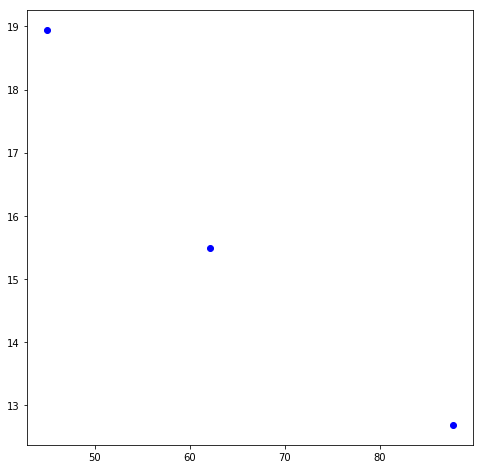

In [16]:
B = len(perf_aif_dataset)
print(B)
ni = np.zeros(B)
nm = np.zeros(B)

for n in np.arange(B):
    images, masks, names = perf_aif_dataset[n]
    ni[n] = np.linalg.norm(images)
    nm[n] = np.linalg.norm(masks)

    if(ni[n] < 1):
        print(names, ni[n])
    
plt.figure(figsize=(8,8))    
plt.plot(ni, nm, 'bo')

In [22]:
print(perf_aif_dataset)
NUM_TRAIN = len(perf_aif_dataset)-1

batch_size = 2

loader_for_train = DataLoader(perf_aif_dataset, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_for_val = DataLoader(perf_aif_dataset, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(perf_aif_dataset))))

Perfusion AIF Dataset
  image root: ./data
  Number of samples: 3
  Number of masks: 3
  image shape: 64 64 48
  myo mask shape: 1 64 48



torch.Size([2, 64, 64, 48])
torch.Size([2, 1, 64, 48])
torch.Size([64, 48, 64, 2])


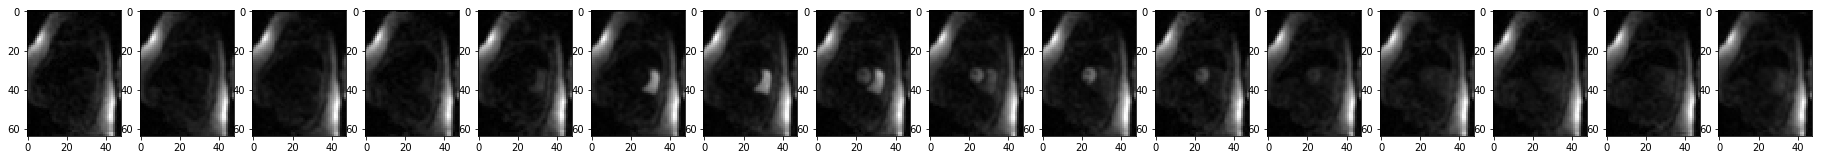

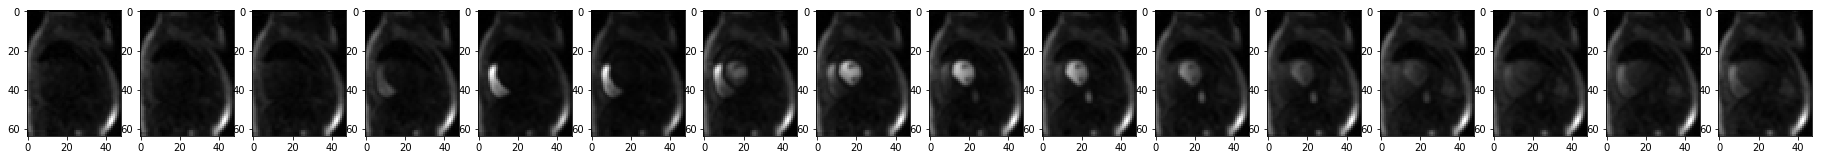

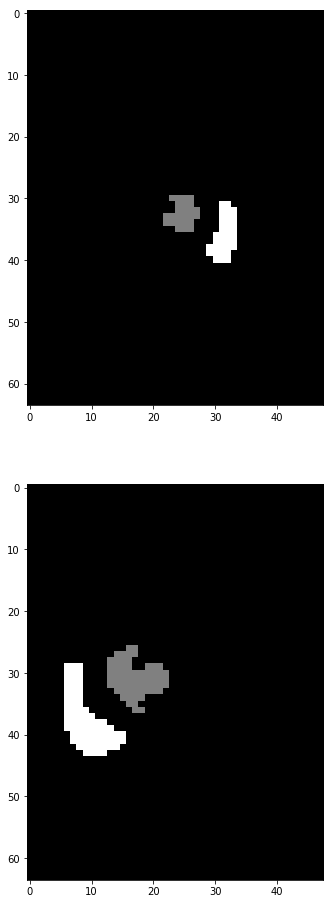

In [23]:
iter_train = iter(loader_for_train)
print(iter_train)
images, masks, names = iter_train.next()

print(images.shape)
print(masks.shape)

ia = np.transpose(images, (2, 3, 1, 0))
print(ia.shape)

for n in range(masks.shape[0]):
    a = utils.cmr_ml_utils_plotting.plot_image_array(np.transpose(np.squeeze(images[n, 0:-1:4,:,:]), (1, 2, 0)), columns=16, figsize=[32,8])
    
a = utils.cmr_ml_utils_plotting.plot_image_array(np.transpose(np.squeeze(masks), (1, 2, 0)), columns=1, figsize=[16,16])

## Construct data loaders

In [24]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")

using device: cuda
Let's use 2 GPUs!


## Data augmentation

In [25]:
class RandomFlip1stDim(object):
    """Randomly flip the first dimension of numpy array.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img ([N RO E1 ... ]): Image to be flipped.
        Returns:
            res: Randomly flipped image.
        """
        #print(img[0].shape)
        #print(img[1].shape)
            
        if random.random() < self.p: 
                                
            a = np.transpose(img[0], [1, 2, 0])
            a = np.flipud(a)
            a = np.transpose(a, [2, 0, 1])
            
            b = np.transpose(img[1], [1, 2, 0])
            b = np.flipud(b)
            b = np.transpose(b, [2, 0, 1])
            return ( a.copy(), b.copy(), img[2] )
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)
    
class RandomFlip2ndDim(object):
    """Randomly flip the second dimension of numpy array.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img ([N RO E1 ... ]): Image to be flipped.
        Returns:
            res: Randomly flipped image.
        """
        if random.random() < self.p:    
            a = np.transpose(img[0], [1, 2, 0])
            a = np.fliplr(a)
            a = np.transpose(a, [2, 0, 1])
            
            b = np.transpose(img[1], [1, 2, 0])
            b = np.fliplr(b)
            b = np.transpose(b, [2, 0, 1])
            return ( a.copy(), b.copy(), img[2] )
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)

In [26]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import scipy
from scipy import ndimage

# probs should be a 64x48 torch tensor
def adaptive_thresh_cpu(probs, p_thresh=0.5, p_thresh_max=0.988):
    # Try regular adaptive thresholding first
    #p_thresh_max  = 0.988 # <-- Should not be too close to 1 to ensure while loop does not go over.

    p_thresh_incr = 0.01
    #p_thresh = 0.5

    RO = probs.shape[0]
    E1 = probs.shape[1]

    try:
        number_of_blobs = float("inf")
        blobs = np.zeros((RO,E1))
        while number_of_blobs > 1 and p_thresh < p_thresh_max:
            mask = (probs > torch.max(probs) * p_thresh).float()
            blobs, number_of_blobs = ndimage.label(mask)
            p_thresh += p_thresh_incr  # <-- Note this line can lead to float drift.
    
        if(number_of_blobs == 1):
            return mask

        if(number_of_blobs == 0):
            mask = np.zeros((RO, E1))
            print("adaptive_thresh_cpu, did not find any blobs ... ", file=sys.stderr)
            sys.stderr.flush()
            return mask

        ## If we are here then we cannot isolate a singular blob as the LV.
        ## Select the largest blob as the final mask.
        biggest_blob = (0, torch.zeros(RO,E1))
        for i in range(number_of_blobs):
            one_blob = torch.tensor((blobs == i+1).astype(int), dtype=torch.uint8)
            area = torch.sum(one_blob)
            if(area > biggest_blob[0]):
                biggest_blob = (area, one_blob)

        return biggest_blob[1]

    except Exception as e:
        print("Error happened in adaptive_thresh_cpu ...")
        print(e)
        sys.stderr.flush()
        mask = np.zeros((RO,E1))

    return mask

In [27]:
def compute_dice_scores(best_model, loader, aif_trainer, binary_seg=False):
    # get dice for all LV in validation set
    dice_scores = []
    cases = []
    best_model = best_model.cuda() 

    ind = 0

    best_model.eval()  # set model to evaluation mode
           
    for t, (x, y, names) in enumerate(loader):        

        x = x.to(aif_trainer.x_dtype).cuda() 
        y = y.to(aif_trainer.y_dtype).cuda()
       
        with torch.no_grad():
            scores = best_model(x)

        # loss = aif_trainer.compute_loss(scores, y)

        if(binary_seg):
            probs = F.sigmoid(scores)
        else:
            m = torch.nn.Softmax(dim=1)
            probs = m(scores)

        probs = probs.cpu().detach()

        N = x.shape[0]
        
        aif_mask = y.cpu().detach().numpy()        
            
        for n in range(N):
            
            if(binary_seg):
                lv_probs = probs[n, 0, :, :]
            else:
                lv_probs = probs[n, 1, :, :]
            # lv_mask = training.adaptive_thresh(lv_probs, device=torch.device('cpu'), p_thresh=0.5)
            #lv_mask = lv_mask.cpu().detach().numpy()
            
            #lv_probs = lv_probs.cpu().detach().numpy()
            #lv_probs = np.squeeze(lv_probs)
            
            lv_probs = lv_probs.cpu().detach()
            lv_mask = adaptive_thresh_cpu(lv_probs, p_thresh=0.5)
                        
            lv_mask = lv_mask.detach().numpy()
            lv_aif_mask = np.zeros(lv_mask.shape)
            lv_aif_mask[np.where(np.squeeze(aif_mask[n, 0, :,:]==1))] = 1

            ds = training.dice(lv_aif_mask, lv_mask)

            if(ds<0.1):
                print(names[n])
                curr_probs = probs[n, :, :, :].numpy()
                curr_probs = np.transpose(curr_probs, (2, 1, 0))
                a = utils.cmr_ml_utils_plotting.plot_image_array(np.squeeze(curr_probs), columns=8, figsize=[16,16])
                a = utils.cmr_ml_utils_plotting.plot_image_array(lv_aif_mask, columns=8, figsize=[16,16])
                a = utils.cmr_ml_utils_plotting.plot_image_array(lv_mask, columns=8, figsize=[16,16])
    
            dice_scores.append(ds)
            cases.append(names[n])
    
    return dice_scores, cases

In [28]:
def get_failed_cases(dice_scores, cases, thres=0.5, print_failed=True):
    total_samples = len(dice_scores)
    sucess_samples = 0
    failed_cases = []
    failed_dices = []
    for k in range(total_samples):
        if(dice_scores[k]>=thres):
            sucess_samples = sucess_samples + 1
        else:
            if(print_failed):
                print("case %s, dice %f " % (cases[k], dice_scores[k]))
                
            failed_cases.append(cases[k])
            failed_dices.append(dice_scores[k])

    success_rate = sucess_samples/total_samples
    print("Total test samples is ", total_samples)  
    print("Success rate is ", success_rate)  
    
    return failed_cases, failed_dices, success_rate

In [29]:
def load_apply_model_multi_class(img_dir, case_name, model, device):
    
    data_dir = os.path.join(img_dir, case_name)

    model_device = device
    
    print(data_dir)

    Gd = np.load(os.path.join(data_dir, 'aif.npy'))
    RO, E1, N = Gd.shape

    try:
        aif_mask = np.load(os.path.join(data_dir, 'aif_masks_final.npy'))
    except:
        aif_mask = np.load(os.path.join(data_dir, 'aif_masks.npy'))

    Gd = Gd[:,:,0:64]
    s = int((E1-48)/2)
    Gd = Gd[:,s:s+48,:]

    Gd = np.transpose(Gd, (2, 0, 1))
    Gd = np.reshape(Gd, (1, Gd.shape[0], Gd.shape[1], Gd.shape[2]))
    Gd /= np.max(Gd)

    aif = torch.from_numpy(Gd).float()
    aif = aif.to(device=model_device)
    model.eval() 
    with torch.no_grad():
        scores = model(aif)

    m = torch.nn.Softmax(dim=1)
    probs = m(scores)

    probs = probs.cpu().detach()
    
    lv_probs = probs[0, 1, :, :]
    lv_mask = training.adaptive_thresh(lv_probs, device=torch.device('cpu'), p_thresh=0.5)
    
    lv_mask = lv_mask.cpu().detach().numpy()
    probs = probs.cpu().detach().numpy()
    probs = np.squeeze(np.transpose(probs, (2, 3, 1, 0)))
    
    a = utils.cmr_ml_utils_plotting.plot_image_array(probs, columns=8, figsize=[16,16])
    a = utils.cmr_ml_utils_plotting.plot_image_array(aif_mask, columns=8, figsize=[16,16])
    a = utils.cmr_ml_utils_plotting.plot_image_array(lv_mask, columns=8, figsize=[16,16])
    
    return probs, lv_mask, aif_mask

## Train with multi-class trainer

In [30]:
# data augmenation for random flipping
transform = torchvision.transforms.Compose([RandomFlip1stDim(0.5), RandomFlip2ndDim(0.5)])

In [31]:
perf_aif_dataset.transform = transform

In [32]:
perf_aif_dataset.which_mask = 'lv_rv'
num_classes = 3
class_for_accu = [1, 2]
class_weights = np.ones(num_classes)
class_weights[1] = 5
p_thres = [0.5, 0.5, 0.75]

lv_rv
(1, 64, 48)


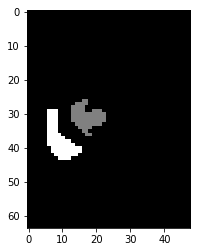

In [33]:
print(perf_aif_dataset.which_mask)

sample = perf_aif_dataset[1]

print(sample[1].shape)

plt.figure()
plt.imshow(np.squeeze(sample[1]))

torch.Size([4, 64, 64, 48])
torch.Size([4, 1, 64, 48])
tensor(1.)
tensor(2.)
(3, 68, 202)
(3, 68, 202)
torch.Size([4, 64, 64, 48])
torch.Size([4, 1, 64, 48])


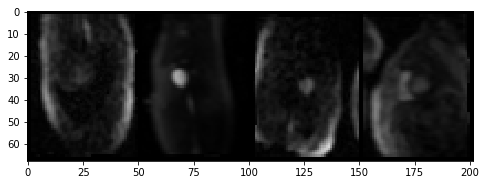

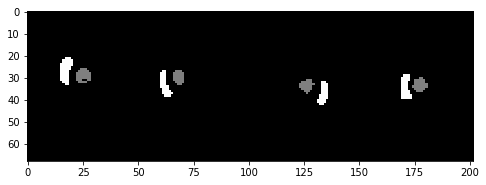

In [28]:
images, masks, names = iter_train.next()

B, C, RO, E1 = images.shape

print(images.shape)
print(masks.shape)
print(torch.max(images))
print(torch.max(masks))

a = images[:,32,:,:]
a = torch.reshape(a, (B, 1, RO, E1))

plt.figure(figsize=(8, 8))
show(make_grid(a.double(), nrow=8, padding=2, normalize=False, scale_each=True))

plt.figure(figsize=(8, 8))
show(make_grid(masks.double(), nrow=8, padding=2, normalize=True, scale_each=False))

X = images.type(torch.FloatTensor)
y = masks.type(torch.FloatTensor)
print(X.shape)
print(y.shape)

In [ ]:
def perform_training(hyperpara, perf_aif_dataset, loader_for_train, loader_for_val):
    
    num_epochs = hyperpara['num_epochs']
    print_every = 100000

    inplanes = hyperpara['inplanes']
    layers = hyperpara['layers']
    layers_planes = hyperpara['layers_planes']
    
    class_weights = hyperpara['class_weights']
    jaccard_weight = hyperpara['jaccard_weight']
    
    print('======================================================')
    print('num_epochs ', num_epochs)
    print('inplanes ', inplanes)
    print('layers ', layers)
    print('layers_planes ', layers_planes)
    print('class_weights ', class_weights)
    print('jaccard_weight ', jaccard_weight)
    print('======================================================')
    
    perf_aif_dataset.which_mask = 'lv_rv'
    num_classes = 3
    class_for_accu = [1, 2]
    p_thres = [0.5, 0.5, 0.75]

    print(perf_aif_dataset.aif[0].shape)
    C, H, W = perf_aif_dataset.aif[0].shape

    model = models.GadgetronResUnet18(F0=C, 
                              inplanes=inplanes, 
                              layers=layers, 
                              layers_planes=layers_planes, 
                              use_dropout=False, 
                              p=0.5, 
                              H=H, W=W, C=num_classes,
                              verbose=True)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        print("model on multiple GPU ... ")

    patience = 10
    factor = 0.5
    cooldown = 3
    min_lr = 1e-7

    weight_decay=0
    learning_rate = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)

    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay, nesterov=True)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, cooldown=cooldown, min_lr=min_lr, verbose=True)

    CW = np.ones(num_classes)
    CW[1] = class_weights
    criterion = training.LossMulti(class_weights=CW, jaccard_weight=jaccard_weight)

    log_dir = 'aif_training/ResUnet' + '_lr_' + str(learning_rate) + '_epochs_' + str(num_epochs)
    writer = SummaryWriter(log_dir)
    
    aif_trainer = training.GadgetronMultiClassSeg_Perf(model, 
                                   optimizer, 
                                   criterion, 
                                   loader_for_train, 
                                   loader_for_val, 
                                   class_for_accu=class_for_accu,
                                   p_thres = p_thres,
                                   scheduler=scheduler, 
                                   epochs=num_epochs, 
                                   device=device, 
                                   x_dtype=torch.float32, 
                                   y_dtype=torch.long, 
                                   early_stopping_thres = 100,                              
                                   print_every=print_every, 
                                   writer=writer, 
                                   model_folder="perf_training/")
    
    
    epochs_traning, epochs_validation, best_model, loss_all, epochs_acc_class = aif_trainer.train(verbose=True, epoch_to_load=-1, save_model_epoch=True)
    
    dice_scores, cases = compute_dice_scores(best_model, loader_for_val, aif_trainer)
    failed_cases, failed_dices, success_rate = get_failed_cases(dice_scores, cases, thres=0.5, print_failed=False)   
    scipy.io.savemat(os.path.join(img_dir, 'perf_aif_lv_rv_val_failed.mat'), {"cases":failed_cases, "dices":failed_dices, "dice_scores":dice_scores, "cases":cases})
    
    dice_scores_train, cases_train = compute_dice_scores(best_model, loader_for_train, aif_trainer)
    failed_cases_train, failed_dices_train, success_rate_train = get_failed_cases(dice_scores_train, cases_train, thres=0.5, print_failed=False) 

    hyperpara['best_model'] = best_model
    hyperpara['epochs_traning'] = epochs_traning
    hyperpara['epochs_validation'] = epochs_validation
    hyperpara['loss_all'] = loss_all
    hyperpara['epochs_acc_class'] = epochs_acc_class
    
    hyperpara['dice_scores'] = dice_scores
    hyperpara['cases'] = cases
    hyperpara['failed_cases'] = failed_cases
    hyperpara['failed_dices'] = failed_dices
    hyperpara['success_rate'] = success_rate
    
    hyperpara['dice_scores_train'] = dice_scores
    hyperpara['cases_train'] = cases
    
    return hyperpara

In [ ]:
# hyper parameter search
layers_planes = [[96, 128], [128, 128], [128, 256]]
layers = [[2, 3], [3, 3], [3, 4], [4, 4], [4, 5]]
inplanes = [64, 96, 128]

best_success_rate = 0
best_hyperpara = None

hyperpara_all = []

for a in range(len(layers_planes)):
    for b in range(len(layers)):
        for c in range(len(inplanes)):
            
            print('-----------------------------------------------')
            print(a, b, c)
            
            hyperpara = dict()
            
            hyperpara['num_epochs'] = 40
            hyperpara['inplanes'] = inplanes[c]
            hyperpara['layers'] = layers[b]
            hyperpara['layers_planes'] = layers_planes[a]
    
            hyperpara['class_weights'] = 5.0
            hyperpara['jaccard_weight'] = 0.5
            
            k = 12
            batch_size = 256

            # Chunk into k random sets
            chunks = chunk(range(len(perf_aif_dataset)), k)
            listified_chunks = list(chunks)

            val_idxs = listified_chunks[0]
            train_idxs = listified_chunks[1:]
            train_idxs = [item for sublist in train_idxs for item in sublist]

            num_train = len(train_idxs)
            num_val = len(val_idxs)

            loader_for_train = DataLoader(perf_aif_dataset, batch_size=batch_size, 
                                      sampler=sampler.SubsetRandomSampler(train_idxs))

            loader_for_val = DataLoader(perf_aif_dataset, batch_size=batch_size, 
                                    sampler=sampler.SubsetRandomSampler(val_idxs))

            num_train = len(train_idxs)
            print('num_train = %d' % num_train)
            num_val = len(val_idxs)
            print('num_val = %d' % num_val)
            
            hyperpara = perform_training(hyperpara, perf_aif_dataset, loader_for_train, loader_for_val)
            
            # print(hyperpara)
            print('success rate - ', hyperpara['success_rate'])
            
            if(hyperpara['success_rate']>best_success_rate):
                best_success_rate = hyperpara['success_rate']
                best_hyperpara = hyperpara
                
            hyperpara_all.append(hyperpara)

In [34]:
num_epochs = 50
print_every = 100000

# resnet
inplanes = 96
layers=[4, 4]
layers_planes=[128, 128]
growth_rate = 8

#dense net
inplanes = 64
layers=[3, 3]
layers_planes=[16, 32]
growth_rate = 16

# resnet, small
inplanes = 96
layers=[2, 3]
layers_planes=[128, 128]
growth_rate = 8

print(perf_aif_dataset.aif[0].shape)
C, H, W = perf_aif_dataset.aif[0].shape

model = models.GadgetronResUnet18(F0=C, 
                          inplanes=inplanes, 
                          layers=layers, 
                          layers_planes=layers_planes, 
                          use_dropout=False, 
                          p=0.5, 
                          H=H, W=W, C=num_classes,
                          verbose=True)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print("model on multiple GPU ... ")

patience = 10
factor = 0.5
cooldown = 3
min_lr = 1e-7

weight_decay=0
learning_rate = 1e-3

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)

# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay, nesterov=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, cooldown=cooldown, min_lr=min_lr, verbose=True)

criterion = training.LossMulti(class_weights=class_weights, jaccard_weight=0.5)
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()

log_dir = './aif_training/ResUnet' + '_lr_' + str(learning_rate) + '_epochs_' + str(num_epochs)
writer = SummaryWriter(log_dir)

(64, 64, 48)
GadgetronResUnet : F0=64, inplanes=96
------------------------------------------------------------
    GadgetronResUnetInputBlock : input size (64, 64, 48), output size (96, 64, 48) --> (96, 64, 48)
------------------------------------------------------------
    GadgetronResUnet, down layer 0:
        GadgetronResUnet, down layer (64, 48) -> (32, 24)
        GadgetronResUnetBasicBlock : input size (96, 32, 24), output size (128, 32, 24) --> (128, 32, 24)
        GadgetronResUnetBasicBlock : input size (128, 32, 24), output size (128, 32, 24) --> (128, 32, 24)
    GadgetronResUnet, down layer 1:
        GadgetronResUnet, down layer (32, 24) -> (16, 12)
        GadgetronResUnetBasicBlock : input size (128, 16, 12), output size (128, 16, 12) --> (128, 16, 12)
        GadgetronResUnetBasicBlock : input size (128, 16, 12), output size (128, 16, 12) --> (128, 16, 12)
        GadgetronResUnetBasicBlock : input size (128, 16, 12), output size (128, 16, 12) --> (128, 16, 12)
-----

c:\python36\lib\site-packages\torch\cuda\__init__.py:135: UserWarning: 
    Found GPU1 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
c:\python36\lib\site-packages\torch\nn\parallel\data_parallel.py:26: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


model on multiple GPU ... 


In [30]:
aif_trainer = training.GadgetronMultiClassSeg_Perf(model, 
                                   optimizer, 
                                   criterion, 
                                   loader_for_train, 
                                   loader_for_val, 
                                   class_for_accu=class_for_accu,
                                   p_thres = p_thres,
                                   scheduler=scheduler, 
                                   epochs=num_epochs, 
                                   device=device, 
                                   x_dtype=torch.float32, 
                                   y_dtype=torch.long, 
                                   early_stopping_thres = 100,                              
                                   print_every=print_every,
                                   small_data_mode = False, 
                                   writer=writer, 
                                   model_folder="aif_training/")

In [31]:
epochs_traning, epochs_validation, best_model, loss_all, epochs_acc_class = aif_trainer.train(verbose=True, epoch_to_load=-1, save_model_epoch=True)

50
Start training ... 
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
----------------------------------------



    107.86/5.88 seconds for Training/Validation --- Tra acc = 0.7579, Val acc = 0.8384 --- Tra loss = 0.0725, Val loss = 0.0194, --- class acc = 0.8389748649194851, 0.8378937777028216



    72.04/5.52 seconds for Training/Validation --- Tra acc = 0.8411, Val acc = 0.8614 --- Tra loss = 0.0183, Val loss = 0.0164, --- class acc = 0.8681851914607895, 0.8546765785546454



    69.01/4.92 seconds for Training/Validation --- Tra acc = 0.8554, Val acc = 0.8716 --- Tra loss = 0.0164, Val loss = 0.0158, --- class acc = 0.8842165152384245, 0.8590390625073149



    66.07/4.99 seconds for Training/Validation --- Tra acc = 0.8606, Val acc = 0.8754 --- Tra loss = 0.0157, Val loss = 0.0151, --- class acc = 0.8850794268248751, 0.8656503635307744



    63.27/4.62 seconds for Training/Validation --- Tra acc = 0.8655, Val acc = 0.8601 --- Tra loss = 0.0150, Val loss = 0.0148, --- class acc = 0.8577941371519064, 0.8624379239397789



    63.01/4.83 seconds for Training/Validation --- Tra acc = 0.8678, Val acc = 0.8836 --- Tra loss = 0.0147, Val loss = 0.0148, --- class acc = 0.8969535663052465, 0.8703327910440651



    62.07/4.76 seconds for Training/Validation --- Tra acc = 0.8726, Val acc = 0.8708 --- Tra loss = 0.0141, Val loss = 0.0141, --- class acc = 0.8709107469392303, 0.8706873677035192



    63.97/4.83 seconds for Training/Validation --- Tra acc = 0.8733, Val acc = 0.8725 --- Tra loss = 0.0141, Val loss = 0.0143, --- class acc = 0.8726676929945685, 0.8722473283513509



    64.01/4.43 seconds for Training/Validation --- Tra acc = 0.8761, Val acc = 0.8814 --- Tra loss = 0.0137, Val loss = 0.0135, --- class acc = 0.889044950929607, 0.8737420697454524



    60.93/4.84 seconds for Training/Validation --- Tra acc = 0.8772, Val acc = 0.8794 --- Tra loss = 0.0136, Val loss = 0.0136, --- class acc = 0.8824341281148411, 0.8763195798586794



    64.55/5.00 seconds for Training/Validation --- Tra acc = 0.8779, Val acc = 0.8713 --- Tra loss = 0.0136, Val loss = 0.0138, --- class acc = 0.8683579793255258, 0.8742578383945893



    64.00/4.64 seconds for Training/Validation --- Tra acc = 0.8793, Val acc = 0.8804 --- Tra loss = 0.0134, Val loss = 0.0136, --- class acc = 0.8839144153540109, 0.8768632967428645
Epoch    11: reducing learning rate of group 0 to 1.0000e-04.



    61.73/4.64 seconds for Training/Validation --- Tra acc = 0.8851, Val acc = 0.8857 --- Tra loss = 0.0127, Val loss = 0.0128, --- class acc = 0.8884851669648007, 0.8829957005618746



    63.39/4.95 seconds for Training/Validation --- Tra acc = 0.8861, Val acc = 0.8842 --- Tra loss = 0.0125, Val loss = 0.0128, --- class acc = 0.8849557289569742, 0.8833761279214949



    62.06/4.48 seconds for Training/Validation --- Tra acc = 0.8866, Val acc = 0.8849 --- Tra loss = 0.0125, Val loss = 0.0128, --- class acc = 0.8853650755987414, 0.8844196816990268



    61.38/4.30 seconds for Training/Validation --- Tra acc = 0.8869, Val acc = 0.8799 --- Tra loss = 0.0124, Val loss = 0.0129, --- class acc = 0.8793711401700745, 0.8803674728964114



    64.97/4.63 seconds for Training/Validation --- Tra acc = 0.8877, Val acc = 0.8862 --- Tra loss = 0.0124, Val loss = 0.0127, --- class acc = 0.8885312816440659, 0.8838299415712731



    62.42/4.43 seconds for Training/Validation --- Tra acc = 0.8883, Val acc = 0.8890 --- Tra loss = 0.0123, Val loss = 0.0128, --- class acc = 0.8939495251254176, 0.884114970411116



    62.19/4.93 seconds for Training/Validation --- Tra acc = 0.8886, Val acc = 0.8856 --- Tra loss = 0.0123, Val loss = 0.0127, --- class acc = 0.885848073694187, 0.8852951620363435



    62.94/4.81 seconds for Training/Validation --- Tra acc = 0.8890, Val acc = 0.8879 --- Tra loss = 0.0122, Val loss = 0.0128, --- class acc = 0.8916891889855594, 0.8841425492459496



    62.67/4.53 seconds for Training/Validation --- Tra acc = 0.8891, Val acc = 0.8915 --- Tra loss = 0.0122, Val loss = 0.0129, --- class acc = 0.8976745770053004, 0.8853238765025299



    61.97/4.72 seconds for Training/Validation --- Tra acc = 0.8901, Val acc = 0.8871 --- Tra loss = 0.0121, Val loss = 0.0128, --- class acc = 0.890648184435251, 0.8836180192283565



    62.34/5.03 seconds for Training/Validation --- Tra acc = 0.8900, Val acc = 0.8872 --- Tra loss = 0.0121, Val loss = 0.0127, --- class acc = 0.8874394790781082, 0.8869310015114248



    63.75/4.68 seconds for Training/Validation --- Tra acc = 0.8908, Val acc = 0.8863 --- Tra loss = 0.0120, Val loss = 0.0128, --- class acc = 0.8898583354565921, 0.8828392165962139



    62.19/4.70 seconds for Training/Validation --- Tra acc = 0.8915, Val acc = 0.8881 --- Tra loss = 0.0120, Val loss = 0.0128, --- class acc = 0.8919392930466971, 0.8841893570077957



    64.49/4.61 seconds for Training/Validation --- Tra acc = 0.8919, Val acc = 0.8911 --- Tra loss = 0.0119, Val loss = 0.0129, --- class acc = 0.8968852620111102, 0.8854113475474049
Epoch    25: reducing learning rate of group 0 to 1.0000e-05.



    62.37/4.40 seconds for Training/Validation --- Tra acc = 0.8947, Val acc = 0.8925 --- Tra loss = 0.0115, Val loss = 0.0129, --- class acc = 0.8983868062210448, 0.8866178580235657



    61.16/4.53 seconds for Training/Validation --- Tra acc = 0.8957, Val acc = 0.8923 --- Tra loss = 0.0114, Val loss = 0.0128, --- class acc = 0.8988160291545572, 0.8857598071587509



    62.69/4.44 seconds for Training/Validation --- Tra acc = 0.8960, Val acc = 0.8888 --- Tra loss = 0.0113, Val loss = 0.0128, --- class acc = 0.8927377900135482, 0.8848696477346887



    64.90/4.80 seconds for Training/Validation --- Tra acc = 0.8966, Val acc = 0.8896 --- Tra loss = 0.0113, Val loss = 0.0127, --- class acc = 0.8918159682364386, 0.8874150529460962



    62.81/4.81 seconds for Training/Validation --- Tra acc = 0.8968, Val acc = 0.8903 --- Tra loss = 0.0112, Val loss = 0.0130, --- class acc = 0.8941292877050968, 0.8865377219502787



    61.96/4.55 seconds for Training/Validation --- Tra acc = 0.8971, Val acc = 0.8859 --- Tra loss = 0.0112, Val loss = 0.0129, --- class acc = 0.8863643452396558, 0.885440403983097



    63.08/4.44 seconds for Training/Validation --- Tra acc = 0.8973, Val acc = 0.8903 --- Tra loss = 0.0112, Val loss = 0.0129, --- class acc = 0.8956386496670979, 0.8849679941413272



    61.77/4.90 seconds for Training/Validation --- Tra acc = 0.8978, Val acc = 0.8883 --- Tra loss = 0.0111, Val loss = 0.0129, --- class acc = 0.8900679956803729, 0.8864651750398163



    61.83/4.62 seconds for Training/Validation --- Tra acc = 0.8978, Val acc = 0.8906 --- Tra loss = 0.0111, Val loss = 0.0130, --- class acc = 0.8960107344337529, 0.8851642188038373



    62.79/4.87 seconds for Training/Validation --- Tra acc = 0.8983, Val acc = 0.8902 --- Tra loss = 0.0110, Val loss = 0.0131, --- class acc = 0.8938059162202069, 0.8865928009852467



    63.84/4.84 seconds for Training/Validation --- Tra acc = 0.8985, Val acc = 0.8912 --- Tra loss = 0.0110, Val loss = 0.0132, --- class acc = 0.8965860551521396, 0.885889069803152



    65.49/4.54 seconds for Training/Validation --- Tra acc = 0.8991, Val acc = 0.8899 --- Tra loss = 0.0110, Val loss = 0.0131, --- class acc = 0.8931275986756483, 0.8866260543194164



    64.62/4.99 seconds for Training/Validation --- Tra acc = 0.8991, Val acc = 0.8923 --- Tra loss = 0.0109, Val loss = 0.0131, --- class acc = 0.898129374503175, 0.8864650598308385



    63.36/4.38 seconds for Training/Validation --- Tra acc = 0.8993, Val acc = 0.8911 --- Tra loss = 0.0109, Val loss = 0.0132, --- class acc = 0.8956759682323423, 0.8866021073104551
Epoch    39: reducing learning rate of group 0 to 1.0000e-06.



    64.29/5.12 seconds for Training/Validation --- Tra acc = 0.9001, Val acc = 0.8914 --- Tra loss = 0.0108, Val loss = 0.0129, --- class acc = 0.896342841685104, 0.8863923775955449



    65.24/4.97 seconds for Training/Validation --- Tra acc = 0.8999, Val acc = 0.8911 --- Tra loss = 0.0109, Val loss = 0.0130, --- class acc = 0.8944980679856737, 0.8877458106065642



    63.59/5.39 seconds for Training/Validation --- Tra acc = 0.9002, Val acc = 0.8903 --- Tra loss = 0.0108, Val loss = 0.0132, --- class acc = 0.8951165116073301, 0.8855658025549562



    62.55/4.27 seconds for Training/Validation --- Tra acc = 0.9001, Val acc = 0.8918 --- Tra loss = 0.0108, Val loss = 0.0132, --- class acc = 0.895723364840075, 0.8879074140568822



    64.93/4.81 seconds for Training/Validation --- Tra acc = 0.9001, Val acc = 0.8908 --- Tra loss = 0.0108, Val loss = 0.0130, --- class acc = 0.8944959960527868, 0.8871771134900452



    63.04/4.55 seconds for Training/Validation --- Tra acc = 0.9005, Val acc = 0.8923 --- Tra loss = 0.0108, Val loss = 0.0131, --- class acc = 0.8978132118086115, 0.8867984636403684



    61.19/4.68 seconds for Training/Validation --- Tra acc = 0.9005, Val acc = 0.8888 --- Tra loss = 0.0108, Val loss = 0.0131, --- class acc = 0.8932028173371678, 0.8843589574241455



    63.91/4.61 seconds for Training/Validation --- Tra acc = 0.9005, Val acc = 0.8914 --- Tra loss = 0.0108, Val loss = 0.0133, --- class acc = 0.8945610086618425, 0.8882171469932549



    62.09/4.66 seconds for Training/Validation --- Tra acc = 0.9001, Val acc = 0.8904 --- Tra loss = 0.0108, Val loss = 0.0132, --- class acc = 0.8943911705126812, 0.886502094945423



    60.70/4.85 seconds for Training/Validation --- Tra acc = 0.9005, Val acc = 0.8928 --- Tra loss = 0.0108, Val loss = 0.0132, --- class acc = 0.8982749145302996, 0.8874195534110869


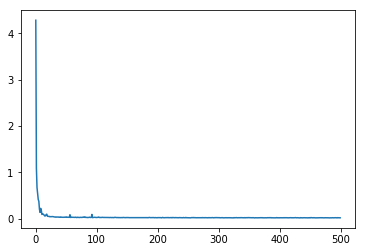

In [34]:
fig = plt.figure()
plt.plot(loss_all[0:500,0], loss_all[0:500,1])

In [35]:
acc, loss, acc_class = aif_trainer.check_validation_test_accuracy(loader_for_val, best_model)
print(acc, loss)
print(acc_class)

0.8929068253572927 0.013101390576345465
[0.89831699 0.88749677]


## Train with binary segmenation

In [ ]:
# data augmenation for random flipping
transform = torchvision.transforms.Compose([RandomFlip1stDim(0.5), RandomFlip2ndDim(0.5)])

In [ ]:
perf_aif_dataset.transform = transform

In [ ]:
perf_aif_dataset.which_mask = 'lv'
num_classes = 1
p_thres = 0.5

In [ ]:
print(perf_aif_dataset.which_mask)

sample = perf_aif_dataset[1]

print(sample[1].shape)

plt.figure()
plt.imshow(np.squeeze(sample[1]))

In [ ]:
images, masks, names = iter_train.next()

B, C, RO, E1 = images.shape

print(images.shape)
print(masks.shape)
print(torch.max(images))
print(torch.max(masks))

a = images[:,32,:,:]
a = torch.reshape(a, (B, 1, RO, E1))

plt.figure(figsize=(16, 16))
show(make_grid(a.double(), nrow=8, padding=2, normalize=False, scale_each=True))

plt.figure(figsize=(16, 16))
show(make_grid(masks.double(), nrow=8, padding=2, normalize=True, scale_each=False))

X = images.type(torch.FloatTensor)
y = masks.type(torch.FloatTensor)
print(X.shape)
print(y.shape)

In [ ]:
num_epochs = 50
print_every = 100000

inplanes = 96
layers=[4, 4]
layers_planes=[128, 128]

print(perf_aif_dataset.aif[0].shape)
C, H, W = perf_aif_dataset.aif[0].shape

model = models.GadgetronResUnet18(F0=C, 
                          inplanes=inplanes, 
                          layers=layers, 
                          layers_planes=layers_planes, 
                          use_dropout=False, 
                          p=0.5, 
                          H=H, W=W, C=num_classes,
                          verbose=True)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print("model on multiple GPU ... ")

patience = 10
factor = 0.5
cooldown = 3
min_lr = 1e-7

weight_decay=0
learning_rate = 1e-3

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)

# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay, nesterov=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, cooldown=cooldown, min_lr=min_lr, verbose=True)

criterion = training.LossBinary(jaccard_weight=0.5)
# criterion = training.LossMulti(class_weights=class_weights, jaccard_weight=0.5)

log_dir = 'aif_training/ResUnet' + '_lr_' + str(learning_rate) + '_epochs_' + str(num_epochs)
writer = SummaryWriter(log_dir)

In [ ]:
aif_trainer = training.GadgetronTwoClassSeg_PerfAIF(model, 
                                   optimizer, 
                                   criterion, 
                                   loader_for_train, 
                                   loader_for_val, 
                                   p_thres=p_thres, 
                                   scheduler=scheduler, 
                                   epochs=num_epochs, 
                                   device=device, 
                                   x_dtype=torch.float32, 
                                   y_dtype=torch.float32, 
                                   early_stopping_thres = 100,                              
                                   print_every=print_every, 
                                   small_data_mode = False, 
                                   writer=writer, 
                                   model_folder="aif_training/")

In [ ]:
epochs_traning, epochs_validation, best_model, loss_all, epochs_acc_class = aif_trainer.train(verbose=True, epoch_to_load=-1, save_model_epoch=True)

## Saving the model

In [37]:
try:
    best_model_cpu = best_model.cpu().module
except:
    
    best_model_cpu = best_model.cpu()
    
print(best_model_cpu)

GadgetronResUnet(
  (input_layer): GadgetronResUnetInputBlock(
    (conv1): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (down_layers): Sequential(
    (Down layer 0): Sequential(
      (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (ResBlock0): GadgetronResUnetBasicBlock(
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [38]:
from datetime import date
today = str(date.today())
print(today)

from time import gmtime, strftime
moment = strftime("%Y%m%d_%H%M%S", gmtime())
print(moment)

2019-07-04
20190705_013036


In [39]:
model_file = './deployment/networks/perf_aif_' + perf_aif_dataset.which_mask + '_network_' + moment + '.pbt'
print(model_file)

./deployment/networks/perf_aif_lv_rv_network_20190705_013036.pbt


In [40]:
torch.save(best_model_cpu, model_file)

In [41]:
model_loaded = torch.load(model_file)
print(model_loaded)

GadgetronResUnet(
  (input_layer): GadgetronResUnetInputBlock(
    (conv1): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (down_layers): Sequential(
    (Down layer 0): Sequential(
      (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (ResBlock0): GadgetronResUnetBasicBlock(
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1